# importing 

In [71]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
from sklearn.cluster import KMeans
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
df = pd.read_csv('Madinah_data.csv')

In [4]:
df

,PostalCode,Neighborhood,Lat,Long
0,42311,Bada'ah,24.472544,39.607427
1,42311,Al Manakhah,24.470527,39.602358
2,42311,Bani Khidrah,24.464277,39.608091
3,42313,Bani Abdul Ashhal,24.478975,39.616919
4,42316,Qurban,24.452750,39.612170
5,42315,Al Mughaisilah,24.456612,39.599381
6,42315,Al Suqya,24.462326,39.593049
7,42312,As Sih,24.472296,39.592744
8,42319,Mahzur,24.440636,39.643437
9,42317,Al Iskan,24.457860,39.638233


In [5]:
CLIENT_ID = 'CLIENT_ID' 
CLIENT_SECRET = 'CLIENT_SECRET'
VERSION = '20180604'

In [6]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
Madinah_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Lat'],
                                   longitudes=df['Long']
                                  )

Bada'ah
Al Manakhah
Bani Khidrah
Bani Abdul Ashhal
Qurban
Al Mughaisilah
Al Suqya
As Sih
Mahzur
Al Iskan
Al Aridh
Al Anabis
Al Fath
Al Qiblatayn
Al Khatim


In [11]:
Madinah_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bada'ah,24.472544,39.607427,Dar Al Iman InterContinental (دار الإيمان إنتر...,24.471807,39.608753,Hotel
1,Bada'ah,24.472544,39.607427,Saja Al-Madinah Hotel,24.473803,39.607655,Hotel
2,Bada'ah,24.472544,39.607427,Anwar Al Madinah Mövenpick (فندق أنوار المدينة...,24.471569,39.607839,Hotel
3,Bada'ah,24.472544,39.607427,I Love Madinah (أنا أحب المدينة),24.471614,39.609199,Gift Shop
4,Bada'ah,24.472544,39.607427,The Beautiful Names of Allah Exhibition (معرض ...,24.469822,39.607687,Museum


In [12]:
Madinah_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Al Anabis,10,10,10,10,10,10
Al Aridh,11,11,11,11,11,11
Al Fath,17,17,17,17,17,17
Al Iskan,15,15,15,15,15,15
Al Khatim,4,4,4,4,4,4
Al Manakhah,13,13,13,13,13,13
Al Mughaisilah,4,4,4,4,4,4
Al Qiblatayn,19,19,19,19,19,19
Al Suqya,2,2,2,2,2,2


In [64]:
test = Madinah_venues.groupby('Neighborhood').count().reset_index()

## Visualization

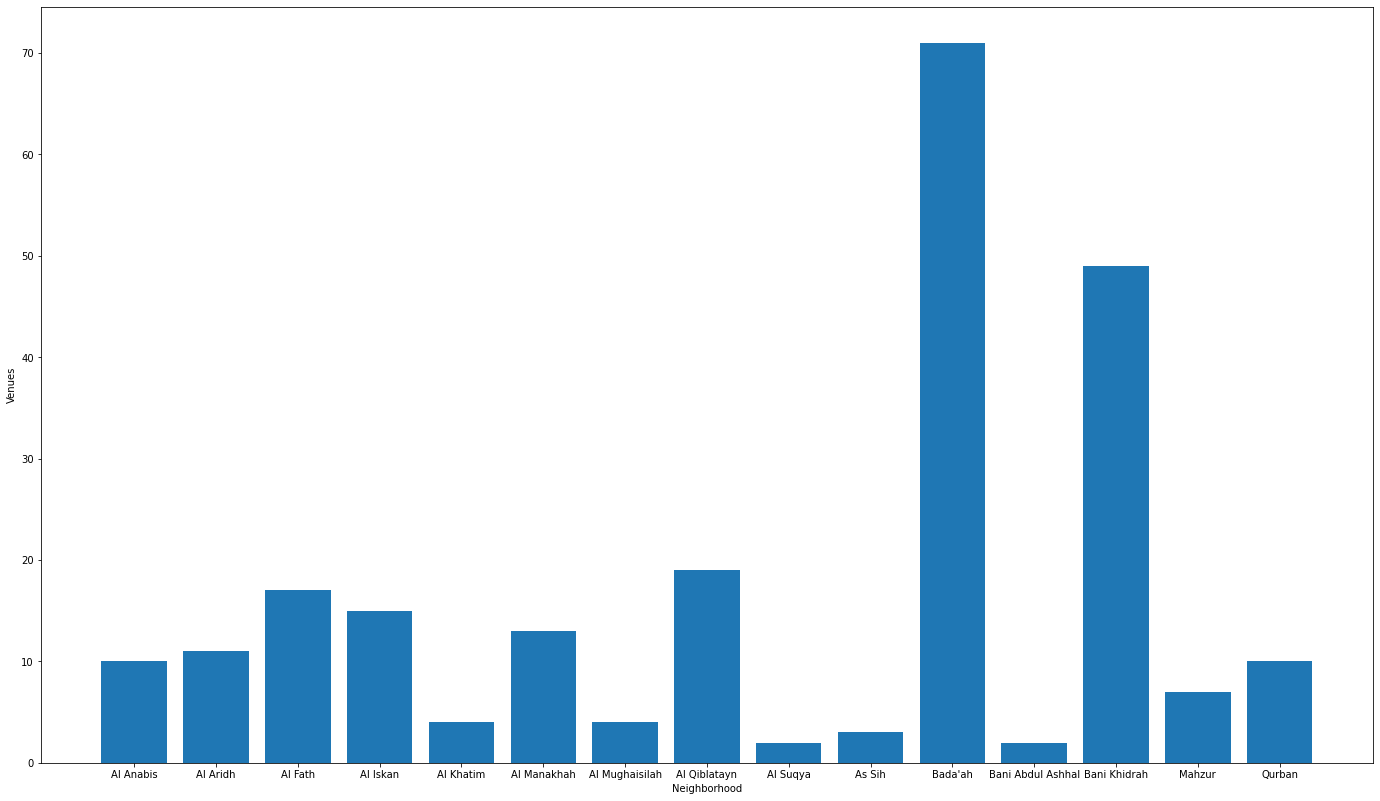

In [84]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_size_inches(18.5, 10.5)
plt.xlabel("Neighborhood")
plt.ylabel("Venues")
ax.bar(test['Neighborhood'],test['Venue'])
plt.show()

In [56]:
madinah_onehot = pd.get_dummies(Madinah_venues[['Venue Category']], prefix="", prefix_sep="")
madinah_onehot.insert(loc=0, column='Neighborhood', value=Madinah_venues['Neighborhood'] )
madinah_onehot.shape

(237, 75)

In [102]:
madinah_onehot.columns

Index(['Neighborhood', 'Afghan Restaurant', 'African Restaurant',
       'American Restaurant', 'Antique Shop', 'Arts & Crafts Store',
       'BBQ Joint', 'Bakery', 'Big Box Store', 'Boarding House',
       'Border Crossing', 'Breakfast Spot', 'Business Service', 'Café',
       'Candy Store', 'Coffee Shop', 'Dairy Store', 'Department Store',
       'Dessert Shop', 'Donut Shop', 'Electronics Store', 'Falafel Restaurant',
       'Farmers Market', 'Fast Food Restaurant', 'Food & Drink Shop',
       'Food Court', 'Food Truck', 'French Restaurant', 'Fried Chicken Joint',
       'Furniture / Home Store', 'Garden', 'Gift Shop', 'Grocery Store',
       'Health Food Store', 'History Museum', 'Hostel', 'Hotel', 'Hotel Pool',
       'Ice Cream Shop', 'Intersection', 'Juice Bar', 'Kids Store',
       'Lebanese Restaurant', 'Lounge', 'Men's Store',
       'Middle Eastern Restaurant', 'Mobile Phone Shop', 'Museum',
       'National Park', 'Pakistani Restaurant', 'Park', 'Pharmacy',
       'Pizza Pla

In [19]:
madinah_grouped = madinah_onehot.groupby('Neighborhood').mean().reset_index()
madinah_grouped.head(20)


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arts & Crafts Store,BBQ Joint,Bakery,Big Box Store,Boarding House,...,Supermarket,Swiss Restaurant,Tech Startup,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Turkish Restaurant,Warehouse Store,Water Park
0,Al Anabis,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.00
1,Al Aridh,0.00,0.090909,0.000000,0.000000,0.00,0.0,0.090909,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.00
2,Al Fath,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Al Iskan,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,Al Khatim,0.00,0.000000,0.000000,0.000000,0.25,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25
5,Al Manakhah,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Al Mughaisilah,0.25,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.00
7,Al Qiblatayn,0.00,0.000000,0.052632,0.000000,0.00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.00
8,Al Suqya,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,As Sih,0.00,0.000000,0.000000,0.333333,0.00,0.0,0.333333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = madinah_grouped['Neighborhood']

for ind in np.arange(madinah_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madinah_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Al Anabis,Middle Eastern Restaurant,Turkish Restaurant,Restaurant,Coffee Shop,Fast Food Restaurant,Fried Chicken Joint,Café,Food Court,Falafel Restaurant,Farmers Market
1,Al Aridh,Smoke Shop,Middle Eastern Restaurant,African Restaurant,Grocery Store,Warehouse Store,Intersection,Bakery,Juice Bar,Coffee Shop,Fried Chicken Joint
2,Al Fath,Coffee Shop,Middle Eastern Restaurant,Electronics Store,Real Estate Office,Candy Store,Fast Food Restaurant,Furniture / Home Store,Intersection,Juice Bar,National Park
3,Al Iskan,Sandwich Place,Middle Eastern Restaurant,Pizza Place,Donut Shop,Café,Ice Cream Shop,Juice Bar,Coffee Shop,Lounge,Farmers Market
4,Al Khatim,Water Park,Pharmacy,Arts & Crafts Store,Hotel Pool,Toy / Game Store,Food Truck,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant


## Clustres


In [109]:
# set number of clusters
kclusters = 5

madinah_grouped_clustering = madinah_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madinah_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 4, 4, 0, 2, 0, 4, 0, 0], dtype=int32)

In [113]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

madinah_merged =  df


madinah_grouped_clustering = madinah_merged.drop('Neighborhood', 1)

# merge toronto_grouped with df to add latitude/longitude for each neighborhood
madinah_merged = madinah_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

madinah_merged.head()

,PostalCode,Neighborhood,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,42311,Bada'ah,24.472544,39.607427,3,Hotel,Shopping Mall,Pizza Place,Ice Cream Shop,Museum,Gift Shop,Donut Shop,Fast Food Restaurant,Boarding House,Lounge
1,42311,Al Manakhah,24.470527,39.602358,3,Hotel,Breakfast Spot,Pharmacy,Middle Eastern Restaurant,Plaza,Grocery Store,Gift Shop,Garden,Furniture / Home Store,Fried Chicken Joint
2,42311,Bani Khidrah,24.464277,39.608091,3,Hotel,Coffee Shop,History Museum,Ice Cream Shop,Museum,Plaza,Café,Pakistani Restaurant,Middle Eastern Restaurant,Men's Store
3,42313,Bani Abdul Ashhal,24.478975,39.616919,1,Hotel,Donut Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint
4,42316,Qurban,24.452750,39.612170,4,Juice Bar,Afghan Restaurant,BBQ Joint,Restaurant,Shopping Mall,Kids Store,Fried Chicken Joint,Ice Cream Shop,Pharmacy,Garden


In [114]:
neighborhoods_venues_sorted.head()


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Al Anabis,Middle Eastern Restaurant,Turkish Restaurant,Restaurant,Coffee Shop,Fast Food Restaurant,Fried Chicken Joint,Café,Food Court,Falafel Restaurant,Farmers Market
1,0,Al Aridh,Smoke Shop,Middle Eastern Restaurant,African Restaurant,Grocery Store,Warehouse Store,Intersection,Bakery,Juice Bar,Coffee Shop,Fried Chicken Joint
2,0,Al Fath,Coffee Shop,Middle Eastern Restaurant,Electronics Store,Real Estate Office,Candy Store,Fast Food Restaurant,Furniture / Home Store,Intersection,Juice Bar,National Park
3,0,Al Iskan,Sandwich Place,Middle Eastern Restaurant,Pizza Place,Donut Shop,Café,Ice Cream Shop,Juice Bar,Coffee Shop,Lounge,Farmers Market
4,4,Al Khatim,Water Park,Pharmacy,Arts & Crafts Store,Hotel Pool,Toy / Game Store,Food Truck,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant


## map

In [115]:
address = 'Medina, SA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Medina are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Medina are 24.471153, 39.6111216.


In [116]:

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madinah_merged['Lat'], madinah_merged['Long'], madinah_merged['Neighborhood'], madinah_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters